In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import json
import os
import yaml
from dask.distributed import Client

In [4]:
!ls -l ~/.dlio_profiler/

total 8
-rwx------ 1 haridev haridev 659 Nov 17 16:37 configuration.sh
-rw------- 1 haridev haridev  95 Nov 17 16:43 configuration.yaml


In [6]:
with open(f'/g/g92/{os.getenv("USER")}/.dlio_profiler/configuration.yaml', 'r') as file:
    dlp_yaml = yaml.safe_load(file)

In [7]:
# to make this notebook in dev mode.
import sys
sys.path.insert(0,dlp_yaml["app"])
sys.path

['/usr/workspace/iopp/software/dlio-profiler',
 '/usr/WS2/iopp/software/dlio-profiler/examples/dlp_analyzer',
 '/usr/WS2/iopp/software/dlio-profiler/examples/dlp_analyzer',
 '/usr/workspace/iopp/projects/digio',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python39.zip',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9/lib-dynload',
 '',
 '/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages']

In [8]:
import dlp_analyzer
print(dlp_analyzer.__file__)
from dlp_analyzer.main import DLPAnalyzer,get_dlp_configuration,update_dlp_configuration,setup_logging,setup_dask_cluster, reset_dask_cluster, get_dlp_configuration

/usr/workspace/iopp/software/dlio-profiler/dlp_analyzer/__init__.py


In [9]:
dask_run_dir = os.path.join(dlp_yaml["app"], "dlp_analyzer", "dask", "run_dir")
dask_run_dir

'/usr/workspace/iopp/software/dlio-profiler/dlp_analyzer/dask/run_dir'

In [15]:
with open (os.path.join(dask_run_dir, f"scheduler_{os.getenv('USER')}.json"), "r") as f:
    dask_scheduler = json.load(f)
dask_scheduler

{'type': 'Scheduler',
 'id': 'Scheduler-d7d73c4e-ccbb-40cc-86fb-cf0b5d292959',
 'address': 'tcp://134.9.71.28:10005',
 'services': {'dashboard': 8787},
 'started': 1700270013.9290059,
 'workers': {}}

In [16]:
app_name = "resnet" # resnet cosmoflow unet3d mummi deepspeed dlio_resnet dlio_cosmoflow

In [17]:
def get_conditions_cosmoflow(json_object):
    app_io_cond = "TFReader.parse_image" in json_object["name"] # Cosmoflow
    compute_cond = "compute" in json_object["name"] # Cosmoflow
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_resnet(json_object):
    app_io_cond = "IO" == json_object["cat"] # Resnet50
    compute_cond = "cpu" in json_object["name"] or "compute" in json_object["cat"] # Resnet50
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_unet3d(json_object):
    app_io_cond = "NPZReader.read_index" in json_object["name"] # Unet3d
    compute_cond = "compute" in json_object["name"] # Unet3d
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_dlio_resnet(json_object):
    app_io_cond = "read_index" in json_object["name"] # Unet3d
    compute_cond = "compute" in json_object["name"] # Unet3d
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond


In [18]:
condition_fn = None #
if app_name == "cosmoflow":
    filename = "/usr/WS2/iopp/kogiou1/dlio_benchmark/hydra_log/cosmoflow/2023-10-31-10-27-24/.trace*.pfw.gz"
    condition_fn = get_conditions_cosmoflow
elif app_name == "dlio_cosmoflow":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark/hydra_log/cosmoflow/2023-11-01-18-47-58/.trace*.pfw.gz"
    condition_fn = get_conditions_cosmoflow
elif app_name == "resnet":
    filename = "/usr/workspace/iopp/dlio_paper_results/resnet_50_1node_4ppn/*.pfw.gz"
    condition_fn = get_conditions_resnet
elif app_name == "unet3d":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark_logs/unet3d/node_32_ppn_4/.trace*.pfw.gz"
    condition_fn = get_conditions_unet3d
elif app_name == "mummi":
    filename = "/usr/workspace/iopp/dlp_traces/mummi-32-node/trace*.pfw.gz"
elif app_name == "deepspeed":
    filename = "/usr/workspace/iopp/dlp_traces/deepspeed_8_4ppn/*.pfw.gz"
elif app_name == "dlio_resnet":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark/hydra_log/resnet50/2023-11-01-10-52-58/.trace*.pfw.gz"
    condition_fn = get_conditions_dlio_resnet
else:
    raise Exception("Unknown App name")

In [91]:
conf = update_dlp_configuration(dask_scheduler=dask_scheduler["address"], verbose=True, 
                                log_file=f"./dlp_{os.getenv('USER')}.log", rebuild_index=False, time_approximate=True, 
                                host_pattern=r'lassen(\d+)', time_granularity=30e6, skip_hostname=True, conditions=condition_fn)


In [92]:
conf = get_dlp_configuration()
conf.time_approximate

True

In [93]:
setup_logging()

In [94]:
setup_dask_cluster()

In [95]:
reset_dask_cluster()

In [96]:
analyzer = DLPAnalyzer(filename)

In [97]:
analyzer.events.head()

,name,cat,pid,tid,ts,te,dur,tinterval,trange,hostname,compute_time,io_time,app_io_time,total_time,filename,phase,size
0,opendir,POSIX,62695,125390,1871874,1872150,276,<NA>,0.0,x3006c0s13b0n0,<NA>,276,<NA>,276,/lus/eagle/projects/datascience/ImageNet/ILSVR...,2,<NA>
1,__xstat64,POSIX,62695,125390,1872864,1872879,15,<NA>,0.0,x3006c0s13b0n0,<NA>,15,<NA>,15,/lus/eagle/projects/datascience/ImageNet/ILSVR...,2,<NA>
2,opendir,POSIX,62695,125390,1872905,1873102,197,<NA>,0.0,x3006c0s13b0n0,<NA>,197,<NA>,197,/lus/eagle/projects/datascience/ImageNet/ILSVR...,2,<NA>
3,__xstat64,POSIX,62695,125390,1876254,1876274,20,<NA>,0.0,x3006c0s13b0n0,<NA>,20,<NA>,20,/lus/eagle/projects/datascience/ImageNet/ILSVR...,2,<NA>
4,opendir,POSIX,62695,125390,1876297,1876515,218,<NA>,0.0,x3006c0s13b0n0,<NA>,218,<NA>,218,/lus/eagle/projects/datascience/ImageNet/ILSVR...,2,<NA>


In [98]:
#analyzer.events[["io_time","compute_time","app_io_time"]].max().compute() / 1e6

In [99]:
# hydra_log/cosmoflow/2023-11-01-18-47-58/
items = analyzer.summary()
items

/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))
/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .app

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 1 ['x3006c0s13b0n0']                                                                  │
│                ├── Processes: 4 [62695,62698]                                                                   │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 4                                                                               │
│                │   └── I/O: 34                                                                                  │
│                └── Events Recorded: 9064150                                                                     │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 1276825                                                                               │
│                    ['/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_X…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/val',                          │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_X.…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/val/nXXXXXXXX',                │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX',              │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train', '<NA>']                │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 761.168 sec                                                                  │
│                │   ├── Overall App Level I/O: 758.514 sec                                                       │
│                │   ├── Unoverlapped App I/O: 623.617 sec                                                        │
│                │   ├── Unoverlapped App Compute: 0.000 sec                                                      │
│                │   ├── Compute: 134.897 sec                                                                     │
│                │   ├── Overall I/O: 605.890 sec                                                                 │
│                │   ├── Unoverlapped I/O: 470.992 sec                                                            │
│                │   └── Unoverlapped Compute: 0.000 sec                                                          │
│                ├── Transfer size distribution by function                                                       │
│                │   ├── Function       |min   |25    |mean  |median|75    |max   |                               │
│                │   ├── opendir        |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── __xstat64      |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── open64         |NA    |nan   |n

In [100]:
analyzer.events.groupby("name")["size"].sum().compute() / 1024**3

name
__fxstat64                       0.000000
__xstat64                        0.000000
close                            0.000000
lseek64                          0.000000
open64                           0.000000
opendir                          0.000000
read                           136.129872
cpu-gpu-transfer                 0.000000
model-compute-backward-prop      0.000000
model-compute-forward-prop       0.000000
real_IO.iter                     0.000000
real_IO.yield                    0.000000
Name: size, dtype: double[pyarrow]

In [101]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].sum().groupby(["trange", "name"]).max().groupby([ "name"]).sum().compute() / 1e6

name
__fxstat64                      16.374204
__xstat64                        0.361658
close                           13.684002
cpu-gpu-transfer                 0.000000
lseek64                          0.204211
model-compute-backward-prop      0.000000
model-compute-forward-prop       0.000000
open64                          15.335467
opendir                          1.125259
read                           570.389110
real_IO.iter                     0.000000
real_IO.yield                    0.000000
Name: io_time, dtype: double[pyarrow]

In [102]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].count().groupby(["trange", "name"]).sum().groupby([ "name"]).sum().compute()

name
__fxstat64                     1274819
__xstat64                        12515
close                          1274797
cpu-gpu-transfer                     0
lseek64                        2639837
model-compute-backward-prop          0
model-compute-forward-prop           0
open64                         1274822
opendir                          12523
read                           2549801
real_IO.iter                         0
real_IO.yield                        0
Name: io_time, dtype: int64[pyarrow]

In [103]:
timeline = analyzer.plots._create_timeline( analyzer.events).compute()

/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


In [104]:
timeline

,phase,index,size,io_time,app_io_time
trange,,,,,
0.0,2,57203,3286277758,20981624,0
1.0,2,78084,4536723584,25873271,0
2.0,2,79012,4498540005,25894710,0
3.0,2,83955,4835225564,25658236,0
4.0,2,85769,4902985343,25478400,0
...,...,...,...,...,...
23.0,3,0,0,0,30128731
24.0,1,0,0,0,0
24.0,3,0,0,0,30003118


/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


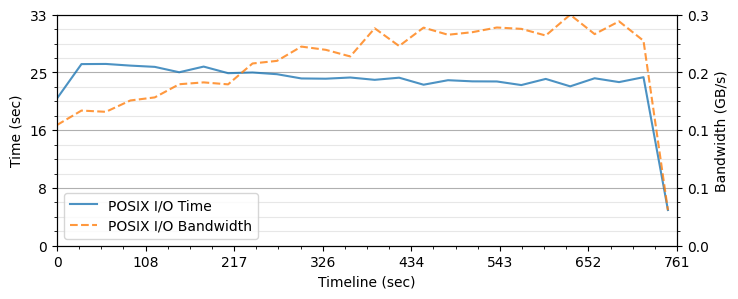

In [105]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='gb',
    figsize=(8, 3),
    line1_label='POSIX I/O Time',
    line2_label='POSIX I/O Bandwidth',
    time_col='io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)

In [106]:
fig.savefig(f'{app_name}_posix_io_time.pdf', format='pdf', bbox_inches='tight')

/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


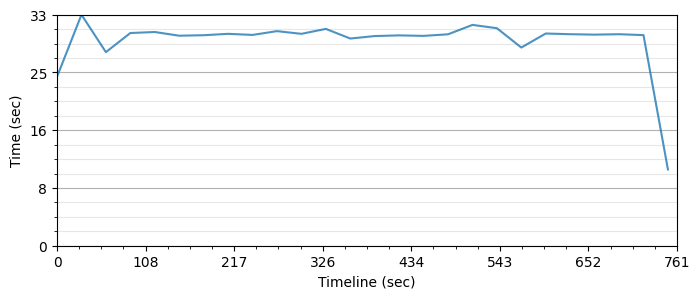

In [111]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='gb',
    figsize=(8, 3),
    line1_label='App. I/O Time',
    line2_label='App. I/O Bandwidth',
    time_col='app_io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)
ax2.set_visible(False)

In [108]:
fig.savefig(f'{app_name}_app_io_time.pdf', format='pdf', bbox_inches='tight')

/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


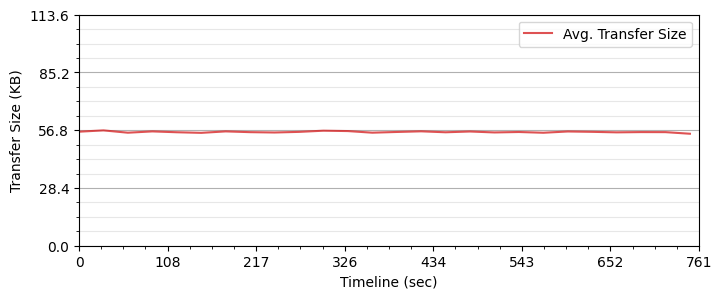

In [109]:
fig, ax = analyzer.plots.xfer_size_timeline(
    figsize=(8, 3),
    unit='kb',
    x_num_ticks=8,
)

In [110]:
fig.savefig(f'{app_name}_xfer_size.pdf', format='pdf', bbox_inches='tight')

In [43]:
analyzer.events.query("cat == 'POSIX'").groupby("name")["size"].mean().compute() / (1024**2)

name
__fxstat64        NaN
__xstat64         NaN
close             NaN
lseek64           NaN
open64            NaN
opendir           NaN
read          0.05467
Name: size, dtype: double[pyarrow]

In [44]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","pid","tid","name"])["io_time"].sum().groupby(["trange","name"]).max().groupby("name").sum().compute() / 1e6

name
__fxstat64     14.238569
__xstat64       0.361658
close          11.435908
lseek64         0.184910
open64         13.368323
opendir         1.125259
read          533.845061
Name: io_time, dtype: double[pyarrow]

In [45]:
val = analyzer.events.groupby(["trange"]).agg({"io_time":[min,max],"compute_time":[min,max],"app_io_time":[min,max]}).sum().compute()
val

io_time       min          0
              max    3614661
compute_time  min        255
              max    3313428
app_io_time   min         26
              max    9089266
dtype: uint64[pyarrow]

In [46]:
val = analyzer.events["app_io_time"].max().compute()
val

9089266

In [47]:
import dask
val1, val2 = dask.compute(analyzer.events["ts"].min() /1e6 , analyzer.events["ts"].max()/1e6)
val2 - val1

761.167636

In [48]:
analyzer.events["hostname"].unique().compute()[:2]

0    x3006c0s13b0n0
Name: hostname, dtype: string

In [49]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","name"])["dur"].max().sum().compute() / 1e6

4.01724

In [50]:
analyzer.events.query("name == 'open'").groupby("trange")["dur"].max().sum().compute() / 1e6

0.0

In [51]:
analyzer.events.groupby(["cat","name"])["dur"].sum().compute()

cat                      name                       
POSIX                    __fxstat64                       444448241
                         __xstat64                          1041137
                         close                            342150487
                         lseek64                            5377747
                         open64                           417437820
                         opendir                            3807348
                         read                           16581944325
IO                       real_IO.iter                     311363925
                         real_IO.yield                   2708610270
communication-except-io  cpu-gpu-transfer                  37165103
compute                  model-compute-backward-prop      444288066
                         model-compute-forward-prop        50921978
Name: dur, dtype: uint64[pyarrow]

In [52]:
3766287/3.8/1e6, 1022647/3.8/1e6, 1080267/3.8/1e6, 178451/3.8/1e6, (1259124+153089)/3.8/1e6

(0.9911281578947368,
 0.26911763157894736,
 0.28428078947368424,
 0.04696078947368421,
 0.371635)